Weak perturbation
=================

new version 2026

In this numerical experiment, one considers the propagation of a small perturbation in a collisionless plasma model. The perturbation is initiated by a thin slab of fluid slowly moving with respect to the surrounding resting fluid. The slab is translationally invariant in the $y$ direction and moving in the $x$ direction.

The perturbation is said to be "small" because the initial speed of the slab is small with respect to the ion acoustic speed. In such a case, the mode is linear and we aim in this practical work at calculating the speed at which this small perturbation is propagating and verify that it is the ion acoustic speed.

In [1]:
import os
import sys

In [2]:
home = os.environ['HOME']
work_path = os.path.join(home, 'far/farTeach/2026/weak')
src_path = os.path.join(home, 'far/PHARE')
build_path = os.path.join(home, 'far/builds/release/ufunc')

In [3]:
sys.path.append(os.path.join(src_path, "pyphare"))

In [4]:
import subprocess
import pyphare
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
from pyphare.core.operators import dot, cross, sqrt, modulus, grad
from pyphare.core.ufuncs import gF, peakIds
import numpy as np
from numpy import polyfit

## Run the `PHARE` code in dedicated conditions

In [5]:
Ti = 0.01
Te = 0.2

In [6]:
run_path = os.path.join(work_path, 'wp_{0}'.format(Te))

In [7]:
if os.path.isdir(run_path):
    files = os.listdir(run_path)
else:
    files = []

In [8]:
if 'PYTHONPATH' in os.environ:
    os.environ['PYTHONPATH'] += os.pathsep + os.path.join(src_path, "pyphare")
else:
    os.environ['PYTHONPATH'] = os.pathsep + os.path.join(src_path, "pyphare")
os.environ['PYTHONPATH'] += os.pathsep + build_path

All the path are now set, so that a **PHARE** simulation is ready to run. If the H5 files of  the run doesn't exist, the cell below will then run the code and strore the data using a h5 files in the dir given in the simulation script `wp.py`

In [9]:
if 'ions_charge_density.h5' not in files :
    os.chdir(work_path)
    # subprocess.run(['/usr/bin/python3', work_path+'/wp.py', str(Te)], env=os.environ)
    subprocess.run(['mpirun', '-n', '4', '/usr/bin/python3', work_path+'/wp.py', str(Te)], env=os.environ)

In [10]:
run  = Run(run_path)

In [11]:
times = np.asarray((20, 40, 60, 80, 100))

In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [13]:
time = times[3]

In [14]:
V = run.GetVi(time)

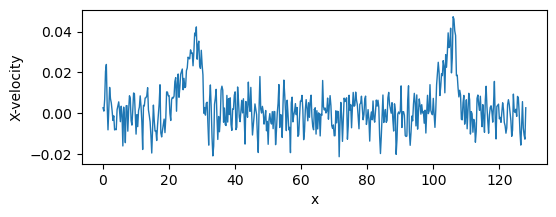

In [15]:
fig, ax = plt.subplots(figsize=(6,2))

V.plot(qty='x', ax=ax, ls='solid', lw=1.0, color='tab:blue', ylabel='X-velocity')

The data obtained from the **PHARE** simlulation are too noisy so that the peaks can easily be found. We then create a new patch hierarchy as a deepcopy of the former one, but for which all the dataset are smoothed using a Gaussian filter. This one is then the Gaussian filter of `pyphare`.

In [16]:
v = gF(V, sigma=6)

We then use a `pyphare` `find_peaks`, called `peaksIds` to find the peaks (using the same syntax and format as the method of `scipy`)

In [17]:
pks = peakIds(v, names=['x',], height=0.015)

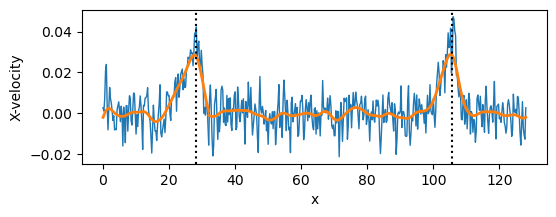

In [18]:
fig, ax = plt.subplots(figsize=(6,2))

V.plot(qty='x', ax=ax, ls='solid', lw=1.0, color='tab:blue', ylabel='X-velocity')
v.plot(qty='x', ax=ax, ls='solid', lw=2.0, color='tab:orange', ylabel='X-velocity')
for p in pks:
    ax.axvline(x=p, color='black', linestyle='dotted')

You can then do the job for a set of times to investigate how the small perturbation is propagating

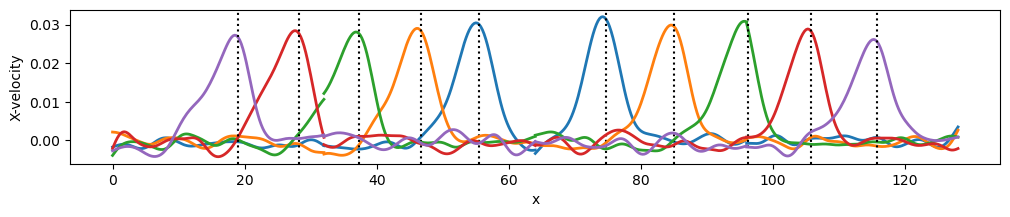

In [19]:
fig, ax = plt.subplots(figsize=(12,2))

pks_plus = []
pks_minus = []

for i, time in enumerate(times):
    V = run.GetVi(time)
    v = gF(V, sigma=6)
    pks = peakIds(v, names=['x',], height=0.015)

    # if i == 0:
    #     pks_plus.append(pks[0]), pks_minus.append(pks[0])
    # else:
    #     pks_minus.append(pks[0]), pks_plus.append(pks[1])
    pks_minus.append(pks[1]), pks_plus.append(pks[0])
    v.plot(qty='x', ax=ax, ls='solid', lw=2.0, color=colors[i], ylabel='X-velocity')
    for p in pks:
        ax.axvline(x=p, color='black', linestyle='dotted')

Text(0, 0.5, 'X-position')

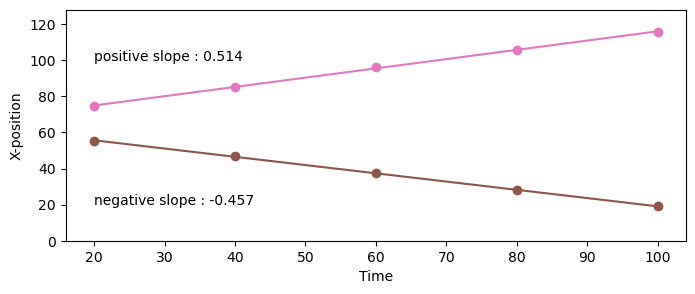

In [20]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(times, pks_minus, marker="o", color=colors[5], ls="None")
slope_m, origin_m = polyfit(times, pks_minus, 1)
ax.plot(times, times*slope_m+origin_m, color=colors[5])

ax.plot(times, pks_plus, marker="o", color=colors[6], ls="None")
slope_p, origin_p = polyfit(times, pks_plus, 1)
ax.plot(times, times*slope_p+origin_p, color=colors[6])

ax.text(20, 100, 'positive slope : {:.3f}'.format(slope_p))
ax.text(20, 20, 'negative slope : {:.3f}'.format(slope_m))

ax.set_ylim([0, 128])
ax.set_xlabel('Time')
ax.set_ylabel('X-position')

In [21]:
v_phi = np.mean(np.abs([slope_m, slope_p]))
print('phase velocity of the mode : {:.3f}'.format(v_phi))

phase velocity of the mode : 0.486


The plasma is not magnetized so that the number of linear mode that can exist is limited... What is the number mode that exist ? 

There exist 3 modes :
* the Bohm and Gross mode
* the light mode
* the ion acouistic mode

But the 2 first modes are very high frequency... above the plasma frequency. Hence, in the hybrid frame, only the ion acoustic mode exist... which should then be the one we observe.

In [22]:
Gamma_e = 1
Gamma_i = 3
print("ion acoustic speed : ", np.sqrt(Gamma_e*Te+Gamma_i*Ti))

ion acoustic speed :  0.47958315233127197


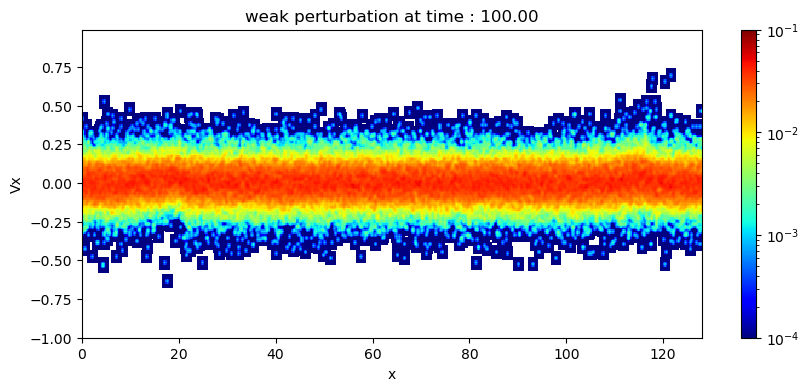

In [23]:
time=100
r = Run(run_path)
ions = r.GetParticles(time, ["protons",])

fig, ax = plt.subplots(figsize=(10,4))

p,f = ions.dist_plot(axis=("x", "Vx"),
                     ax=ax,
                     norm = 0.4,
                     finest=True,
                     gaussian_filter_sigma=1,
                     vmin=-1,vmax=1,
                     dv=0.01,
                     title="weak perturbation at time : {:.2f}".format(time),
                    )